# MACHINE LEARNING

Desired output of the turbine: 
- rotor torque
- converter torque
- power output

In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autotime

from windml.core.functions import load_one

data_dir = Path.cwd().parent.parent / 'Data Turbines - enriched'
turbine_name = 'R80711'
turbine_csv_file = Path(data_dir, f'{turbine_name}.csv')

df = load_one(turbine_csv_file)
df = df.sample(5000)

Loading time: 1.17 seconds.
Memory usage: 65.67 MB.
261812 Lines found.
time: 4.32 s (started: 2024-04-11 21:17:55 +02:00)


In [2]:
y_variable = 'P_avg'
x_list = [ 'Ws_avg', 'Rs_avg', 'Yt_avg', 'Ba_avg' ]

scoring = 'neg_mean_squared_error'
scoring = 'neg_mean_absolute_error'

time: 753 µs (started: 2024-04-11 21:17:59 +02:00)


In [3]:
from sklearn.model_selection import train_test_split
from windml.visualization.custom_plots import scatter_plot

time: 276 ms (started: 2024-04-11 21:17:59 +02:00)


In [4]:
# Separating the target variable 'y' and features 'X'

X = df[x_list] # take most correlated variables
y = df[y_variable].values.reshape(-1, 1)

# Split the dataset into training and testing sets (20% test size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

time: 8.42 ms (started: 2024-04-11 21:18:00 +02:00)


# Linear Regression

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best parameters: {'regressor__fit_intercept': True}
Best score (neg_mean_absolute_error): -129.92000563279367


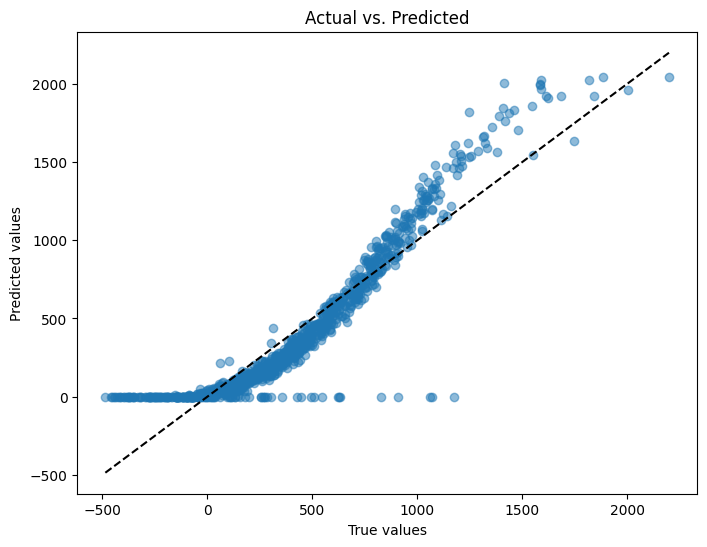

time: 525 ms (started: 2024-04-11 21:18:00 +02:00)


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


# Set up the pipeline with a single step: the linear regression model
lin_pipeline = Pipeline([
    ('regressor', LinearRegression())
])

# Define the parameter grid to search over
lin_param_grid = {
    'regressor__fit_intercept': [True, False],
}

# Initialize GridSearchCV with the pipeline and the parameter grid
lin_grid_search = GridSearchCV(lin_pipeline, lin_param_grid, cv=5, scoring=scoring, verbose=1)

# Fit the GridSearchCV to the training data
lin_grid_search.fit(X_train, y_train)

# After fitting, you can check the best parameters and the best score
print("Best parameters:", lin_grid_search.best_params_)
print(f"Best score ({scoring}):", lin_grid_search.best_score_)

# Predictions
y_pred = lin_grid_search.predict(X_test)

scatter_plot( y_pred, y_test)

# Polynomial Regression

Best parameters: {'poly_features__degree': 3, 'regressor__fit_intercept': False}
Best score (neg_mean_absolute_error): -26.51994842410644


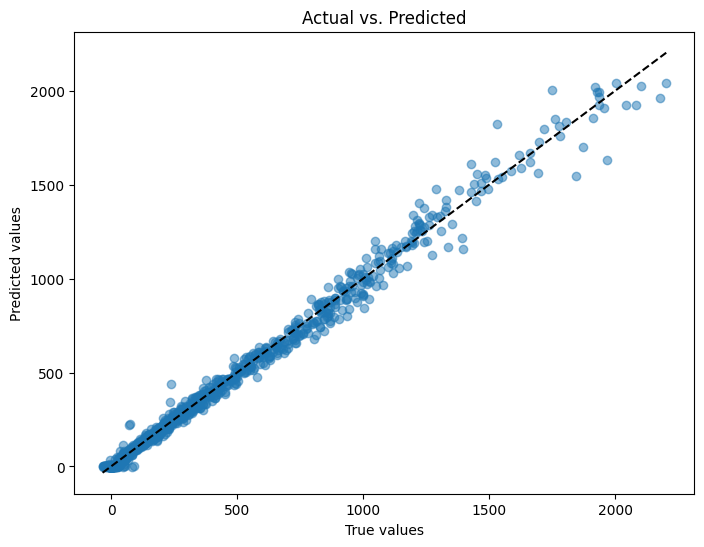

time: 620 ms (started: 2024-04-11 21:18:00 +02:00)


In [6]:
from sklearn.preprocessing import PolynomialFeatures

# Set up the pipeline
poly_pipeline = Pipeline([
    ('poly_features', PolynomialFeatures()),
    ('regressor', LinearRegression())
])

# Define the parameter grid
poly_param_grid = {
    'poly_features__degree': [1, 2, 3],  
    'regressor__fit_intercept': [True, False],
}

# Initialize GridSearchCV
poly_grid_search = GridSearchCV(poly_pipeline, poly_param_grid, cv=5, scoring=scoring)

# Fit
poly_grid_search.fit(X_train, y_train)

# Print best score
print("Best parameters:", poly_grid_search.best_params_)
print(f"Best score ({scoring}):", poly_grid_search.best_score_)

# Predictions
y_pred = poly_grid_search.predict(X_test)

scatter_plot( y_pred, y_test)

In [7]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler

# Set up the pipeline
krr_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Optional but recommended
    ('regressor', KernelRidge())
])

# Define the parameter grid
krr_param_grid = {
    'regressor__kernel': ['rbf', 'manhattan_distances'],
    'regressor__alpha': [1e-3, 1e-2, 0.1, 1],
    'regressor__gamma': [None, 0.1, 1, 10],
}

# Initialize GridSearchCV with the pipeline and parameter grid
krr_grid_search = GridSearchCV(krr_pipeline, krr_param_grid, cv=5, scoring=scoring, verbose=1)

'''
# Fit GridSearchCV to the training data
krr_grid_search.fit(X_train, y_train)

# After fitting, you can check the best parameters and the best score
print("Best parameters:", krr_grid_search.best_params_)
print(f"Best score ({scoring}):", krr_grid_search.best_score_)

# Predictions
y_pred = krr_grid_search.predict(X_test)

scatter_plot( y_pred, y_test)
'''

'\n# Fit GridSearchCV to the training data\nkrr_grid_search.fit(X_train, y_train)\n\n# After fitting, you can check the best parameters and the best score\nprint("Best parameters:", krr_grid_search.best_params_)\nprint(f"Best score ({scoring}):", krr_grid_search.best_score_)\n\n# Predictions\ny_pred = krr_grid_search.predict(X_test)\n\nscatter_plot( y_pred, y_test)\n'

time: 7.21 ms (started: 2024-04-11 21:18:01 +02:00)


# Learning Curve

In [12]:
import widnml 
print(windml)

ModuleNotFoundError: No module named 'widnml'

time: 92.2 ms (started: 2024-04-11 21:19:11 +02:00)


In [10]:
from windml.machine_learning.regression_models import learning_curve

# Generate learning curve data with GridSearchCV
lin_learning_curve_data = learning_curve(
    X, y, LinearRegression, lin_param_grid)

# Plotting the learning curve
plot_learning_curve(learning_curve_data)


ImportError: cannot import name 'learning_curve' from 'windml.machine_learning.regression_models' (/Users/marcodigennaro/Desktop/APPLICATIONS/2024/32_Toqua/WindML/windml/machine_learning/regression_models.py)

time: 46.5 ms (started: 2024-04-11 21:18:45 +02:00)


In [ ]:


# Generate learning curve data with GridSearchCV
learning_curve_data = create_learning_curve_with_grid_search(X, y, model_poly, param_grid_poly, num_points=5)

# Plotting the learning curve
plot_learning_curve(learning_curve_data)


In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor()

param_grid_rf = {
    'n_estimators': [10, 50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split an internal node
}

# Generate learning curve data with GridSearchCV
learning_curve_data = create_learning_curve_with_grid_search(X, y, model_rf, param_grid_rf, num_points=5)

# Plotting the learning curve
plot_learning_curve(learning_curve_data)


Why i did not use PCA


# KERNEL RIDGE REGRESSION

- Define the 'laplacian' kernel: a custom kernel based on L1 distance

### Laplacian (L1) vs Gaussian (L2 or RBF) Kernel
The Gaussian or RBF kernel is defined as:
$$ K_{L1}(x, x') = \exp\left(-\gamma \|x - x'\|\right) $$
$$ K_{L2}(x, x') = \exp\left(-\gamma \|x - x'\|^2\right) $$

- Create a pipeline including scaling and kernel
- define a parameter grid to optimize alpha and gamma and kernel

### 
### Kernel Ridge Regression (KRR)
Kernel Ridge Regression combines Ridge Regression (linear least squares with L2-norm regularization) with the kernel trick. The objective function for KRR is:

$$ \min_{w} \|Xw - y\|^2 + \alpha \|w\|^2 $$

Where:
- $X$ is the matrix of input features.
- $w$ is the vector of coefficients.
- $y$ is the vector of target values.
- $\alpha$ is the regularization parameter.

The kernel trick transforms the input space into a higher-dimensional space using a kernel function $K$, allowing for the learning of non-linear relationships. The KRR model in this higher-dimensional space is given by:

$$ f(x) = \sum_{i=1}^{n} \alpha_i K(x, x_i) $$

Where:
- $K(x, x_i)$ is the kernel function evaluating the similarity between the input vector $x$ and a training example $x_i$.
- $\alpha_i$ are the coefficients solved for in the dual space, not to be confused with the regularization parameter.
- $\alpha$ (regularization parameter) controls the amount of regularization and helps prevent overfitting by penalizing large values of $\alpha_i$.
- $\gamma$ is a parameter of certain kernels (e.g., the RBF kernel), controlling the shape of the kernel function and thus the decision boundary.

For the RBF kernel, often used in KRR, the kernel function is defined as:
$$ K(x, x') = \exp\left(-\gamma \|x - x'\|^2\right) $$

The use of $\gamma$ in the RBF kernel controls the spread of the kernel and influences the model's capacity to handle the data's complexity and noise.
